## Luke Meszar
## Homework 3

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.  How fast does this method converge for values of $p < 2$ and $p > 2$?

* Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.factorized.html#scipy.sparse.linalg.factorized) to be useful. Compare algebraic convergence to that of the Picard method.

* Can you directly implement a Newton linearization?  Either do it or explain what is involved.  How will its nonlinear convergence compare to that of the Newton-Krylov method?

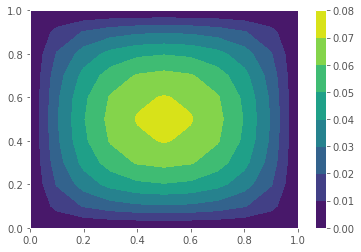

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
plt.style.use('ggplot')
def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = np.linspace(0, 1, m)
    y, x = np.meshgrid(c, c)
    return x, y

def nonlinear2d_div(h, x, y, u, forcing, g0, p, epsiloln, dirichlet=((),())):
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = np.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = np.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            # Stencil to evaluate gradient at four staggered points
            grad = np.array([[-1, 0, 1, 0, 0],
                                [0, -1, 1, 0, 0],
                                [0, 0, -1, 1, 0],
                                [0, 0, -1, 0, 1]]) / h
            # Stencil to average at four staggered points
            avg  = np.array([[1, 0, 1, 0, 0],
                                [0, 1, 1, 0, 0],
                                [0, 0, 1, 1, 0],
                                [0, 0, 1, 0, 1]]) / 2
            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = np.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            ustag = avg @ ustencil
            kappa = 1 + ustag**2
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa[:,None] * grad @ ustencil)
                Jstencil = -div @ (kappa[:,None] * grad
                    + 2*(ustag*(grad @ ustencil))[:,None] * avg)
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()
    J = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J

h = .1
x, y = hgrid(h)
u = 0*x
F, J = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                       lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
deltau = sp.linalg.spsolve(J, -F).reshape(x.shape)
plt.contourf(x, y, deltau)
plt.colorbar();